In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# load data
df = pd.read_csv('data.csv')

In [5]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


<AxesSubplot:>

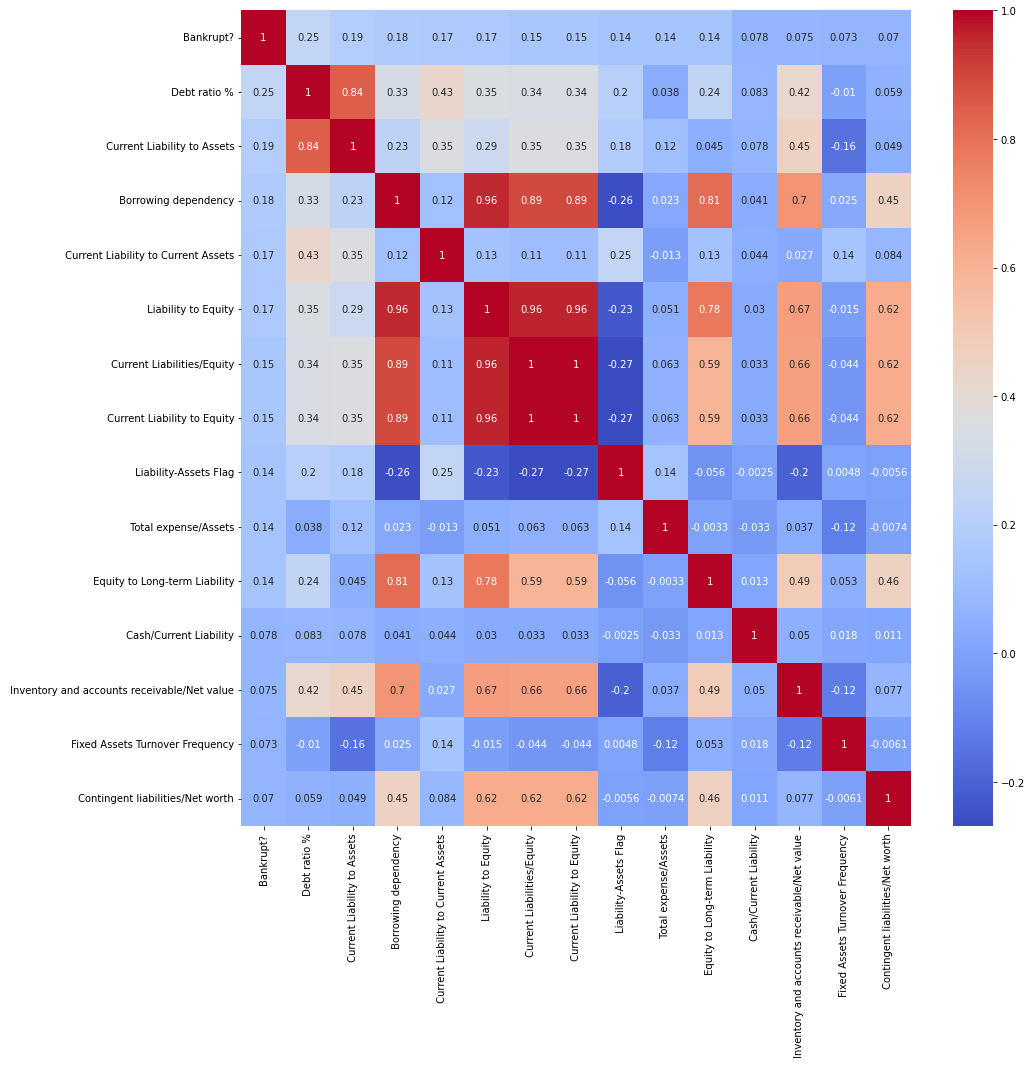

In [9]:
# print correlation matrix of all features
df.corr()
# visualize correlation matrix
# compute the correlation matrix
corr = df.corr()

# select the top 10 most correlated features with the target: 'Bankrupt?'
corr = corr.nlargest(15, 'Bankrupt?')['Bankrupt?'].index

# plot the heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(df[corr].corr(), annot=True, cmap='coolwarm')


In [11]:
# create train, test, validation sets
from sklearn.model_selection import train_test_split

# split data into train and test sets
train, test = train_test_split(df, test_size=0.2, random_state=42)

# split train into train and validation sets
train, val = train_test_split(train, test_size=0.2, random_state=42)

# print shapes of train, test, validation sets
print(train.shape, test.shape, val.shape)


(4364, 96) (1364, 96) (1091, 96)


In [12]:
# save train, test, validation sets
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)
val.to_csv('val.csv', index=False)